FurthVisualizing the innards of the three optimization for adaptive behavior on serial neurogym.

In [1]:
#!/usr/bin/env python
# coding: utf-8
# system
import os
import sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')
from pathlib import Path
import json
# tools
import time
import itertools
from collections import defaultdict
# computation
import math
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
# tasks
import gym
import neurogym as ngym
from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
# models
# from model_dev import RNN_MD
# from model_dev import serial_RNN_MD as RNN_MD
# from utils import get_full_performance
# visualization
import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.dpi'] = 100
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm, trange
import seaborn as sns
from utils import get_logs_and_files, convert_train_to_test_idx


In [2]:
data_folder = './../files/paper_data/cluster_neurogym_thalamus_vs_rnn/'
exp_name= 'random_gates_mul'
print('current folder: ', os.getcwd())
filenames = os.listdir(data_folder + exp_name)
testing_log_files = [logfile for logfile in filenames if logfile.__contains__('testing_log')]
training_log_files = [logfile for logfile in filenames if logfile.__contains__('training_log')]
config_files = [logfile for logfile in filenames if logfile.__contains__('config')]

seed = 14
loops = 1.0
task_rule = 1000.0
no_of_tasks = 5
var4  = 1.0


def load_simulation(data_folder, exp_name, seed, var1, var3, var4, no_of_tasks, dataset):
    search_strs=[f'seed{seed}_', f'tasks_{no_of_tasks}_',dataset, f'{var1:3.1f}_{var3:1.1f}_{var4:1.1f}']
    testing_logs, test_files = get_logs_and_files(data_folder, exp_name, file_sig='testing_log', search_strs=search_strs)
    training_logs, train_files = get_logs_and_files(data_folder, exp_name, file_sig='training_log', search_strs=search_strs)
    configs, config_files = get_logs_and_files(data_folder, exp_name, file_sig='config', search_strs=search_strs)
    config_files
    
    if len(training_logs) > 0:
        testing_log = testing_logs[0]
        training_log = training_logs[0]
        config = configs[0]
        assert len(training_logs) == 1, 'more than one training_log found!'
    else:
        print( f'unable to load {search_strs}!')
        testing_log, training_log, config = None, None, None        
    return config,training_log,testing_log

current folder:  /home/ahummos/code/multiplicative/analysis


In [3]:
Seeds = list(range(3,13))#[6, 7, 8, 10,  14, ]#range(11,15)
Var1 = [0,1] # train or not LU optim SGD, ADam 
Var3 = [0., 0.5, 0.8]# gates sparsity LU LR multiplier ,100] # [(x/10) for x in range(1,5, 1)] #gates_std  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
Var4 = [0.0, 0.1, 0.5, 0.8,1., 1.5, 2.] # gates std few_)shots [(x/10) for x in range(0,6, 4)] #gates_sparsity  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
exp_name = 'iclr_testing'
data_folder = './../files/cluster_iclr_Wz_tests2/'
dataset = 'neurogym'


### Testing for LUs every trial
Seeds = list(range(0,10))#[6, 7, 8, 10,  14, ]#range(11,15)
Var1 = [1] # train or not LU optim SGD, ADam 
Var3 = [100]# gates sparsity LU LR multiplier ,100] # [(x/10) for x in range(1,5, 1)] #gates_std  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
Var4 = [100] # gates std few_)shots [(x/10) for x in range(0,6, 4)] #gates_sparsity  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
exp_name = 'few_shot_testing'
data_folder = './../files/iclr_neurogym_update_every_trial_2LUs/'


# from utils import load_simulation
exps = []
data = defaultdict(list)
no_of_tasks = 5
for var1 in Var1:
    for var3 in Var3:
        for var4 in Var4:
            for seed in Seeds:
                config, training_log, testing_log = load_simulation(data_folder, exp_name, seed, var1, var3, var4, no_of_tasks, dataset)
                if not config is None: # if exp actually loaded and exists.
                    exps.append({'var1': var1, 'var3': var3, 'no_of_tasks': no_of_tasks, 'seed': seed, 'var4': var4})
                    testing_idx = int((15- no_of_tasks) *2) +1
                    data['ttcs'].append(training_log.trials_to_crit[:-testing_idx])
                    data['ttcs40'].append(training_log.trials_to_crit[-testing_idx-20:-testing_idx])
                    # data['ltcs40'].append(training_log.latents_to_crit[-testing_idx-20:-testing_idx])
                    data['latent_updates'].append(training_log.latents_to_crit[:-testing_idx])
                    data['total_compute'].append(np.stack(training_log.latents_to_crit[-testing_idx-20:-testing_idx]) + np.stack(training_log.trials_to_crit[-testing_idx-20:-testing_idx]))
                    data['accuracy'].append(training_log.accuracies[training_log.start_testing_at-500:training_log.start_testing_at])
                    try:
                        data['lu_stamps_acc_improve'].append((training_log.lu_stamps_acc_improve))
                        data['switches'].append(training_log.switch_trialxxbatch[:-testing_idx])
                        data['clock_time'].append(training_log.training_duration)
                    except:
                        print('error: ', exps[-1])
                    # data['total_batches'].append(training_log.stamps[-1])



/tmp/ipykernel_24349/3910762727.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  switch_averages[i] = (np.array(switch_collapse[i]).sum())/ len(switch_collapse[i])
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/tmp/ipykernel_24349/3910762727.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do

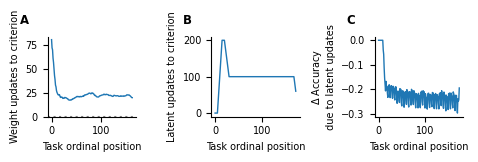

In [8]:
label1 = 'Wz fixed'
label2 = 'Wz learned'
var11 = 0.0
var12 = 1
var3 = 0.5
var4 = 0.0
filter = 5

# label1 = 'Wz Bern'
# label2 = 'Wz Gaus'
var11 = 0.0 # learned
var12 = 1.0
var31 = 0.5 # sparsity
var32 = 0.5
var41 = 0.0 # gaussian std
var42 = 0.0

## Testing for LUs every trial
label1 = '2LUs'
label2 = '2LUs'
var11 = 1.0
var12 = 1
var31 = 100.0
var32 = 100.0
var41 = 100.0
var42 = 100.0

def plot_comparison(label1, label2, var11, var12, var31, var32, var41, var42):
    fig, axes = plt.subplot_mosaic([['A', 'B', 'C']],
                              constrained_layout=False, figsize = [12/2.53, 4/2.53])
    plot_a_second_condition = False
    import matplotlib.transforms as mtransforms
    for label, ax in axes.items():
    # label physical distance to the left and up:
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', va='bottom', fontfamily='arial',weight='bold')
    linewidth = 1
    filter = 10
    ax = axes['A']
    ttcs = np.stack([data['ttcs'][i]  for i in range(len(data['ttcs'])) if exps[i]['var1'] == var11 and exps[i]['var3'] == var31 and exps[i]['var4'] == var41])
    ax.plot(np.convolve(ttcs.mean(0), np.ones(filter)/filter, 'valid'), label = label1, linewidth  = linewidth)
    ttcs = np.stack([data['ttcs'][i]  for i in range(len(data['ttcs'])) if exps[i]['var1'] == var12 and exps[i]['var3'] == var32 and exps[i]['var4'] == var42])
    if plot_a_second_condition:
        ax.plot(np.convolve(ttcs.mean(0), np.ones(filter)/filter, 'valid'), label = label2, linewidth  = linewidth)
        ax.legend()
    ax.set_ylim([0,ax.get_ylim()[1]])
    ax.axhline(0, linestyle=':', color='tab:grey')
    ax.set_ylabel('Weight updates to criterion')
    ax.set_xlabel('Task ordinal position')

    ax = axes['B']
    ttcs = np.stack([data['latent_updates'][i]  for i in range(len(data['latent_updates'])) if exps[i]['var1'] == var11 and exps[i]['var3'] == var31 and exps[i]['var4'] == var41])
    ax.plot(np.convolve(ttcs.mean(0), np.ones(filter)/filter, 'same'), label = label1, color='tab:blue', linewidth  = linewidth)
    ttcs = np.stack([data['latent_updates'][i]  for i in range(len(data['latent_updates'])) if exps[i]['var1'] == var12 and exps[i]['var3'] == var32 and exps[i]['var4'] == var42])
    
    if plot_a_second_condition:
        ax.plot(np.convolve(ttcs.mean(0), np.ones(filter)/filter, 'same'), label = label2, color='tab:orange', linewidth  = linewidth)


    ax.set_ylabel('Latent updates to criterion')
# ax.plot(ax.get_xlim(), [0, 0], ':')
    ax.set_xlabel('Task ordinal position')
    # if var32 > 0.0: fig.text(0.0, 1.3, f'Sparsity {var32}', transform = ax.transAxes, fontsize=10)#, weight='bold')
    ax = axes['C']
    lu_stamps_acc_improve= [data['lu_stamps_acc_improve'][i]  for i in range(len(data['lu_stamps_acc_improve'])) if exps[i]['var1'] == var11 and exps[i]['var3'] == var31 and exps[i]['var4'] == var41]
    switches = [data['switches'][i]  for i in range(len(data['switches'])) if exps[i]['var1'] == var11 and exps[i]['var3'] == var31 and exps[i]['var4'] == var41]

    def extract_improv_averages(lu_stamps_acc_improve, switches):
        switch_master =[]
        for lu_improv, switches in zip(lu_stamps_acc_improve, switches):
            switch_local = [[] for _ in range(len(switches))]
            for switch_i,switch in enumerate(switches):
                if len(lu_improv)> 0:
                    indexes = np.array(lu_improv)[:,0]
                    improvs = np.array(lu_improv)[:,1]
                    bin_entries = np.where(indexes == switch , True, False)
                    if len(improvs[bin_entries ]) > 0: switch_local[switch_i].append(improvs[bin_entries ])
            switch_master.append(switch_local)

        switch_collapse = [[0] for _ in range(len(switches))]
        switch_averages = np.zeros(len(switches))
        for i in range(len(switch_collapse)):
            [switch_collapse[i].extend(switch_m[i]) for switch_m in switch_master if switch_m[i] !=[0]]
    # print(np.array(switch_collapse[i]))
            switch_averages[i] = (np.array(switch_collapse[i]).sum())/ len(switch_collapse[i])
        averages = [np.mean(ss) for ss in switch_collapse]
        return averages

    averages = extract_improv_averages(lu_stamps_acc_improve, switches)

    ax.plot(np.convolve(np.array(averages), np.ones(4)/4)[:-2], label=label1, color='tab:blue', linewidth  = linewidth)

    lu_stamps_acc_improve= [data['lu_stamps_acc_improve'][i]  for i in range(len(data['lu_stamps_acc_improve'])) if exps[i]['var1'] == var12 and exps[i]['var3'] == var32 and exps[i]['var4'] == var42]
    switches = [data['switches'][i]  for i in range(len(data['switches'])) if exps[i]['var1'] == var11 and exps[i]['var3'] == var32 and exps[i]['var4'] == var42]
    averages = extract_improv_averages(lu_stamps_acc_improve, switches)
    if plot_a_second_condition:
        ax.plot(np.convolve(np.array(averages), np.ones(4)/4)[:-2], label=label2, color='tab:orange', linewidth  = linewidth)
        ax.legend()
    ax.set_ylabel(''r'$\Delta$ Accuracy'+ '\n'+ ' due to latent updates ')
    ax.set_xlabel('Task ordinal position')
    clock_times1= [data['clock_time'][i]  for i in range(len(data['clock_time'])) if exps[i]['var1'] == var11 and exps[i]['var3'] == var31 and exps[i]['var4'] == var41]
    clock_times2= [data['clock_time'][i]  for i in range(len(data['clock_time'])) if exps[i]['var1'] == var12 and exps[i]['var3'] == var32 and exps[i]['var4'] == var42]
    # ax.text(10,0.6,  f'{np.stack(clock_times1).mean():2.2f}', color='tab:blue')
    # ax.text(100,0.6,  f'{np.stack(clock_times2).mean():2.2f}', color='tab:orange')
    fig.tight_layout()

plot_comparison(label1, label2, var11, var12, var31, var32, var41, var42)
plt.savefig('./files/pdfs/quantifyingThalamus_WULU.pdf', dpi=300)

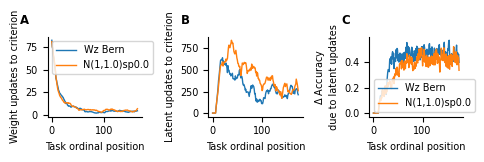

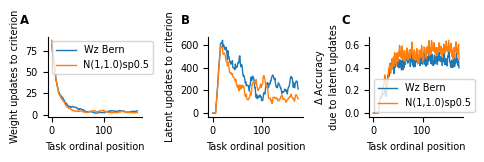

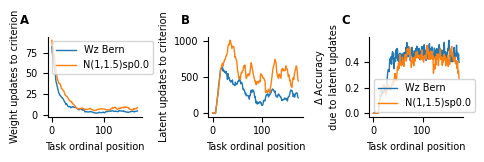

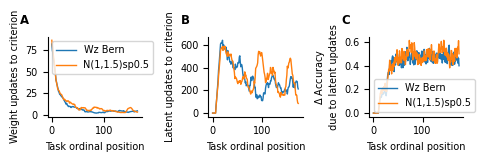

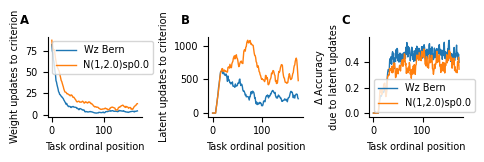

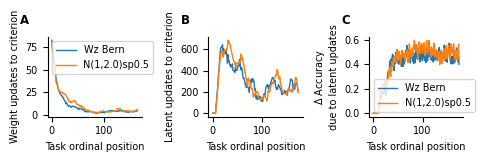

In [ ]:
Var1 = [0,1] # train or not LU optim SGD, ADam 
Var3 = [0., 0.5,]# gates sparsity LU LR multiplier ,100] # [(x/10) for x in range(1,5, 1)] #gates_std  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
# Var4 = [0.0, 0.1, 0.5, 0.8] #+ [1., 1.5, 2.] # gates std few_)shots [(x/10) for x in range(0,6, 4)] #gates_sparsity  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
Var4 = [0.0, ] + [1., 1.5, 2.] # gates std few_)shots [(x/10) for x in range(0,6, 4)] #gates_sparsity  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]

label1 = 'Wz Bern'
label2 = 'N(1,'
var11 = 0.0 # learned
var12 = 0.0
var31 = 0.5 # sparsity
var32 = 0.0
var41 = 0.0 # gaussian std
var42 = 0.8
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
mpl.rcParams['figure.dpi'] = 100
for var42 in Var4[1:]:
    for var32 in Var3:
        plot_comparison(label1, f'{label2}{var42})sp{var32}', var11, var12, var31, var32, var41, var42)

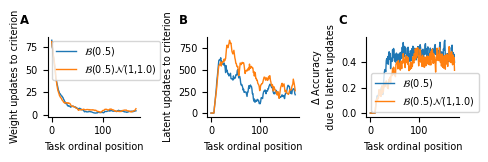

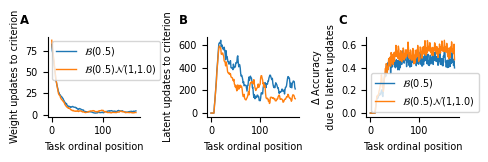

In [ ]:
Var1 = [0,1] # train or not LU optim SGD, ADam 
Var3 = [0., 0.5,]# gates sparsity LU LR multiplier ,100] # [(x/10) for x in range(1,5, 1)] #gates_std  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
# Var4 = [0.0, 0.1, 0.5, 0.8] #+ [1., 1.5, 2.] # gates std few_)shots [(x/10) for x in range(0,6, 4)] #gates_sparsity  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
Var4 = [1., ] # gates std few_)shots [(x/10) for x in range(0,6, 4)] #gates_sparsity  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]

label1 = ''r'$\mathcal{B}$(0.5)'
label2 = ''r'$\mathcal{B}$(0.5)'r'$\mathcal{N}$(1,'
var11 = 0.0 # learned
var12 = 0.0
var31 = 0.5 # sparsity
var32 = 0.0
var41 = 0.0 # gaussian std
var42 = 0.8
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
mpl.rcParams['figure.dpi'] = 100
for var42 in Var4:
    for var32 in Var3:
        plot_comparison(label1, f'{label2}{var42})', var11, var12, var31, var32, var41, var42)
        plt.savefig(f'./files/pdfs/Wz_distribution_Bern{var32}.pdf', dpi=300, )

/tmp/ipykernel_27928/1358375779.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  switch_averages[i] = (np.array(switch_collapse[i]).sum())/ len(switch_collapse[i])
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/tmp/ipykernel_27928/1358375779.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do

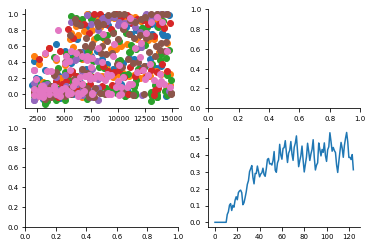

In [ ]:
# Another analysis of LU improvements by binning the data. 
# data['lu_stamps_acc_improve']
fig, axes = plt.subplots(2,2,)

for lu_improv in data['lu_stamps_acc_improve']:
    if len(lu_improv)> 0:
        axes[0,0].scatter(np.array(lu_improv)[:,0], np.array(lu_improv)[:,1])

min_step = 2000
max_step = 14000
whole_N = max_step-min_step
bin_width = whole_N // 50
no_of_bins = whole_N//bin_width
bin_averages = np.zeros(no_of_bins)
bin_dumps = [[] for _ in range(no_of_bins)]
for bin_i in range(no_of_bins):
    bin_begin = bin_i * bin_width
    bin_end = (bin_i+1) * bin_width
    for lu_improv in data['lu_stamps_acc_improve']:
        if len(lu_improv)> 0:
            indexes = np.array(lu_improv)[:,0]
            improvs = np.array(lu_improv)[:,1]
            # matching_indexes = indexes[indexes > bin_begin]
            # matching_indexes = matching_indexes[matching_indexes < bin_end]
            # bin_averages[bin_i] = improvs[indexes > bin_begin  ].mean()
            bin_entries = np.where((indexes > bin_begin) & (indexes < bin_end), True, False)
            bin_averages[bin_i] += improvs[bin_entries ].sum()/(bin_entries.sum()+1)
            if len(improvs[bin_entries ]) > 0: bin_dumps[bin_i].append(improvs[bin_entries ])
axes[1,0].plot(bin_averages)

axes[1,1].plot( ([np.hstack(bin).mean() if len(bin)>0 else 0 for bin in bin_dumps ]))
axes[1,1].set_xlabel('accuracy improved after LU')
#should plots against trial switches
axes[0,1].plot( ([np.hstack(bin).mean() if len(bin)>0 else 0 for bin in bin_dumps ]))
